In [237]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    auc
)






### Task 1  

"Random Sampling: Each of you will use a random sample of 10K instances drawn from the ~61K instances in the secondary mushroom data. Briefly explain the random sampling code
cell(s) in your submission notebook. [4 marks]"

 
To generate my sample, I loaded the full dataset and used random sampling with a fixed random_state value. The random state ensures that I can reproduce the same sample if
needed. I set n=10000 to select exactly 10,000 rows. The sampling method does not change the class distribution and keeps the data structure intact; it simply selects a random
subset of rows for further EDA and modelling tasks.




In [238]:
#generation of sample
Random = 27 #placeholder for random integer later
DataPath = "MushroomDataset/Secondary_data.csv"
DataFrame = pd.read_csv(DataPath, sep=';')  #semicolon seperators 
DataFrameSample = DataFrame.sample(n=10_000, random_state=Random,replace=False)

#output
print("Full dataset shape:",DataFrame.shape)
print("Sampled dataset shape:", DataFrameSample.shape)
DataFrameSample.head()

Full dataset shape: (61069, 21)
Sampled dataset shape: (10000, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
58793,p,26.17,f,g,n,f,p,NaN,y,7.77,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,w
10787,p,2.16,b,NaN,n,f,a,NaN,g,5.54,...,NaN,s,n,NaN,NaN,f,f,NaN,d,a
60682,e,4.65,o,NaN,g,f,f,f,f,5.12,...,NaN,NaN,n,NaN,NaN,f,f,NaN,l,s
11922,e,1.09,f,g,e,t,a,NaN,p,5.67,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
37572,p,1.86,p,t,n,f,a,c,n,5.12,...,NaN,t,y,NaN,NaN,t,e,NaN,m,a


### Task 2  

"Exploratory Data Analysis (EDA): Create appropriate visualisations to explore your dataset and summarise your findings about the data. Highlight your findings relevant to the model  
fitting stage (task 3 onwards). [10 marks]"

For EDA I focused mainly on the categorical features, since the dataset is dominated by categories rather than numeric values. I first printed the basic information and summary
statistics to understand the shape of the data and checked for missing values. I then created a mapped version of the target (Edible/Poisonous) and used simple bar charts to show the
overall class distribution.

Next, I generated stacked bar charts for key categorical features such as *odor*, *spore print color*, *gill color*, *cap color*, *does bruise or bleed*, *habitat* and *season*, comparing how their
categories are distributed across the two classes. Finally, I calculated Mutual Information scores to see which features were most informative. The results showed that several
categorical features have a very strong relationship with the class label, suggesting that non-linear, tree-based models and kNN are more suitable than simple linear models for this
dataset.



In [239]:

plt.style.use('default')
sns.set_theme()

# basic info
DataFrameSample.info()
print(DataFrameSample.describe())

# class labels for plots
ClassMap = {'e': 'Edible', 'p': 'Poisonous'}
DataFrameSample['class_mapped'] = DataFrameSample['class'].map(ClassMap)

# missing values
MissingCounts = DataFrameSample.isna().sum().sort_values(ascending=False)
print(MissingCounts[MissingCounts > 0])

# column types
CatCols = DataFrameSample.select_dtypes(include=['object', 'category']).columns.tolist()
NumCols = DataFrameSample.select_dtypes(include=['number']).columns.tolist()
if 'class' in CatCols: CatCols.remove('class')
if 'class' in NumCols: NumCols.remove('class')
print("Categorical:", CatCols)
print("Numeric:", NumCols)

# mutual information
X = DataFrameSample.drop(columns=['class'])
Y = DataFrameSample['class']
try:
    OHE = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

XCat = OHE.fit_transform(X[CatCols]) if CatCols else np.empty((len(X), 0))
XNum = X[NumCols].to_numpy() if NumCols else np.empty((len(X), 0))
XEncoded = np.hstack([XCat, XNum])

MIScores = mutual_info_classif(XEncoded, Y, discrete_features=True, random_state=Random)
FeatureNamesOHE = OHE.get_feature_names_out(CatCols) if CatCols else np.array([])
AllFeatureNames = list(FeatureNamesOHE) + NumCols
MISeries = pd.Series(MIScores, index=AllFeatureNames).sort_values(ascending=False)
print(MISeries.head(20))

# build dropdown options
SelectedCats = ['odor','spore-print-color','gill-color','cap-color','does-bruise-or-bleed','habitat','season']
ColsToPlotCat = [c for c in SelectedCats if c in CatCols]
ColsToPlotNum = NumCols

PlotOptions = ['Class distribution', 'Missing values', 'Top MI features']
PlotOptions += [f'Categorical: {c}' for c in ColsToPlotCat]

def ShowPlot(Choice):
    plt.figure(figsize=(6,4))

    if Choice == 'Class distribution':
        DataFrameSample['class_mapped'].value_counts().plot(kind='bar')
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')

    elif Choice == 'Missing values':
        MissingCounts[MissingCounts > 0].plot(kind='bar')
        plt.title('Missing Values')
        plt.xticks(rotation=45, ha='right')

    elif Choice == 'Top MI features':
        MISeries.head(15).plot(kind='bar')
        plt.title('Top MI Features')
        plt.xticks(rotation=45, ha='right')

    elif Choice.startswith('Categorical: '):
        Col = Choice.split(': ', 1)[1]
        Tab = pd.crosstab(DataFrameSample[Col], DataFrameSample['class_mapped'], normalize='index')
        Tab.plot(kind='bar', stacked=True)
        plt.title(f'{Col} vs Class')
        plt.ylabel('Proportion')
        plt.xticks(rotation=45, ha='right')


    plt.tight_layout()
    plt.show()

DropdownWidget = Dropdown(options=PlotOptions, description='Plot:')
interact(ShowPlot, Choice=DropdownWidget)


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 58793 to 20396
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 10000 non-null  object 
 1   cap-diameter          10000 non-null  float64
 2   cap-shape             10000 non-null  object 
 3   cap-surface           7754 non-null   object 
 4   cap-color             10000 non-null  object 
 5   does-bruise-or-bleed  10000 non-null  object 
 6   gill-attachment       8366 non-null   object 
 7   gill-spacing          5900 non-null   object 
 8   gill-color            10000 non-null  object 
 9   stem-height           10000 non-null  float64
 10  stem-width            10000 non-null  float64
 11  stem-root             1580 non-null   object 
 12  stem-surface          3812 non-null   object 
 13  stem-color            10000 non-null  object 
 14  veil-type             510 non-null    object 
 15  veil-color          

c:\Users\Fraser Glasgow\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\Fraser Glasgow\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\Fraser Glasgow\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


interactive(children=(Dropdown(description='Plot:', options=('Class distribution', 'Missing values', 'Top MI f…

<function __main__.ShowPlot(Choice)>

### Task 3  
Model Shortlisting based on EDA: Based on your findings from the above EDA task, shortlist three classifiers from the classifiers you learnt in the lab classes. Explain your choice of classifiers in terms of your findings from the above EDA task. [5 marks]

The dataset consists mainly of **categorical features** and the EDA revealed strong  
**non-linear relationships** between several variables (especially *odor* and *spore-print-color*)  
and the target class. Below is a summary of classifier suitability based on the data:

- **Logistic Regression**: Not ideal — assumes linear relationships; categorical data must be heavily encoded.  
- **Shrinkage Logistic Regression**: Better generalisation, but still linear and unsuitable for strong non-linear splits.  
- **k-Nearest Neighbours (kNN)**: Suitable — non-linear; works well when classes form clusters, as seen in EDA.  
- **Decision Tree**: Very suitable — handles categorical data naturally and models non-linear rules effectively.  
- **Random Forest**: Highly suitable — ensemble of trees; reduces overfitting and performs strongly on categorical data.  
- **Naive Bayes**: Not ideal — independence assumption does not match the feature interactions seen in EDA.  
- **ANN / MLPClassifier**: Suitable but more complex; reserved for Task 6.  
- **XGBoost**: Suitable but advanced; used later in Task 6.

### **Chosen Classifiers**
Based on the EDA findings, the following three classifiers will work for model fitting:

1. **Decision Tree** – strong performance on categorical and non-linear data.  
2. **Random Forest** – robust, high-performing ensemble method for categorical features.  
3. **k-Nearest Neighbours** – non-linear baseline exploiting clustering patterns seen in EDA.

These models align best with the structure and patterns observed in the dataset and are expected  
to perform well on the mushroom classification task.




## Task 4  

"Model Fitting: Fit the chosen three classifiers to your sample of data, briefly explaining your
choices and assumptions. [10 marks]"




First im going to make a shared setup for all the classifiers to use

In [240]:
# Split features + target
X = DataFrameSample.drop(columns=['class', 'class_mapped'])
Y = DataFrameSample['class']

# Identify column types
CatCols = X.select_dtypes(include=['object', 'category']).columns.tolist()
NumCols = X.select_dtypes(include=['number']).columns.tolist()

# Safety check (shouldn't be needed but keeps things clean)
if 'class' in CatCols:
    CatCols.remove('class')
if 'class' in NumCols:
    NumCols.remove('class')

# One-hot encoder (compatible with all sklearn versions)
try:
    OneHot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    OneHot = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Preprocessing pipeline (OneHot for categorical, StandardScaler for numeric)
Preprocessor = ColumnTransformer(
    transformers=[
        ('Cat', OneHot, CatCols),
        ('Num', StandardScaler(), NumCols)
    ]
)

# Train/test split (stratified for balanced classes)
XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=Random,
    stratify=Y
)

print("Setup Complete")
print("XTrain shape:", XTrain.shape)
print("YTrain shape:", YTrain.shape)

Setup Complete
XTrain shape: (8000, 20)
YTrain shape: (8000,)


### Decision Tree Classifier

For this step, I will fit a Decision Tree classifier. This model is selected because the EDA shows
that several categorical features, such as odor and spore-print-color, will form very clean and
highly informative splits between edible and poisonous mushrooms. A Decision Tree will be
well-suited to this kind of rule-based, non-linear structure.


**Assumptions:**  
- The dataset contains enough meaningful categorical splits for the tree to separate classes.  
- Overfitting is acceptable at this stage because cross-validation (Task 5) will determine
generalisation performance.  
- One-hot encoding is required so the tree receives clean binary indicator features.


In [241]:
#Decision Tree



DecisionTreePipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', DecisionTreeClassifier(random_state=Random))
])

DecisionTreePipeline.fit(XTrain, YTrain)

DecisionTreeTrainAcc = accuracy_score(YTrain, DecisionTreePipeline.predict(XTrain))

DecisionTreeTrainAccRounded = round(DecisionTreeTrainAcc, 4)
print("Decision Tree Training Accuracy: " + str(DecisionTreeTrainAccRounded))

Decision Tree Training Accuracy: 1.0


### Random Forest Classifier

Next, I will fit a Random Forest classifier. This model will combine many Decision Trees,
each trained on different subsets of the data. I am choosing this model because ensemble
trees tend to be more stable and less prone to overfitting. The EDA indicates strong non-linear
relationships across several categorical features, so a Random Forest will be well-positioned
to capture these patterns.

**Assumptions:**  
- Using many trees will reduce variance and improve generalisation compared to a single
Decision Tree.  
- The dataset is sufficiently large and diverse for an ensemble method to be effective.  
- One-hot encoded features will ensure each tree receives consistent binary inputs.


In [242]:
# Random Forest Classifier

RandomForestPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', RandomForestClassifier(random_state=Random))
])

RandomForestPipeline.fit(XTrain, YTrain)

RandomForestTrainAcc = accuracy_score(
    YTrain,
    RandomForestPipeline.predict(XTrain)
)

RandomForestTrainAccRounded = round(RandomForestTrainAcc, 4)
print("Random Forest Training Accuracy: " + str(RandomForestTrainAccRounded))

# Store test predictions
YTestPredRF = RandomForestPipeline.predict(XTest)
YTestProbaRF = RandomForestPipeline.predict_proba(XTest)[:, 1]


Random Forest Training Accuracy: 1.0


### k-Nearest Neighbours (KNN)

Finally, I will fit a k-Nearest Neighbours classifier. This model is chosen because the EDA
suggests that mushrooms with similar categorical properties tend to belong to the same
class, which is a good fit for a distance-based method like kNN. Instead of learning internal
rules, kNN will classify each new mushroom by comparing it to its closest neighbours.

**Assumptions:**  
- After one-hot encoding, the distance between samples will remain meaningful for
classification.  
- The dataset will exhibit natural clustering, where nearby points tend to share the same
class.  
- Scaling numeric features will ensure that distance calculations are fair across all
dimensions.

In [243]:
# k Nearest Neighbours 

KNNPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', KNeighborsClassifier())
])

KNNPipeline.fit(XTrain, YTrain)

KNNTrainAcc = accuracy_score(YTrain, KNNPipeline.predict(XTrain))
KNNTrainAccRounded = round(KNNTrainAcc, 4)
print("kNN Training Accuracy: " + str(KNNTrainAccRounded))


kNN Training Accuracy: 0.9998


## Task 5  
**Model Evaluation & Model Selection**

To compare the three shortlisted classifiers (Decision Tree, Random Forest, kNN), I will use
5-fold stratified cross-validation on the training data. Stratification keeps the edible/poisonous
class ratio similar in each fold, giving a fairer estimate of performance.


In [244]:
# Shared Cross Validation setup
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=Random)

CVResults = {}   # to store mean/std per model
CVScores = {}    # to store per-fold scores per model

In [245]:
#Decision Tree Cross-Validation

DecisionTreeModel = DecisionTreeClassifier(random_state=Random)

DecisionTreePipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', DecisionTreeModel)
])

DecisionTreeScores = cross_val_score(
    DecisionTreePipeline,
    XTrain,
    YTrain,
    cv=CV,
    scoring='accuracy'
)

DecisionTreeMean = DecisionTreeScores.mean()
DecisionTreeStd = DecisionTreeScores.std()

CVResults['DecisionTree'] = {'Mean': DecisionTreeMean, 'Std': DecisionTreeStd}
CVScores['DecisionTree'] = DecisionTreeScores

print("Decision Tree  CV Scores:", DecisionTreeScores)
DecisionTreeMeanRounded = round(DecisionTreeMean, 4)
DecisionTreeStdRounded = round(DecisionTreeStd, 4)
print("Decision Tree Mean: " + str(DecisionTreeMeanRounded) + ", Std: " + str(DecisionTreeStdRounded))

Decision Tree  CV Scores: [0.994375 0.994375 0.991875 0.99625  0.993125]
Decision Tree Mean: 0.994, Std: 0.0015


In [246]:
#Random Forest Cross-Validation

RandomForestModel = RandomForestClassifier(random_state=Random)

RandomForestPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', RandomForestModel)
])

RandomForestScores = cross_val_score(
    RandomForestPipeline,
    XTrain,
    YTrain,
    cv=CV,
    scoring='accuracy'
)

RandomForestMean = RandomForestScores.mean()
RandomForestStd = RandomForestScores.std()

CVResults['RandomForest'] = {'Mean': RandomForestMean, 'Std': RandomForestStd}
CVScores['RandomForest'] = RandomForestScores

print("Random Forest  CV Scores:", RandomForestScores)
RandomForestMeanRounded = round(RandomForestMean, 4)
RandomForestStdRounded = round(RandomForestStd, 4)
print("Random Forest Mean: " + str(RandomForestMeanRounded) + ", Std: " + str(RandomForestStdRounded))


Random Forest  CV Scores: [1. 1. 1. 1. 1.]
Random Forest Mean: 1.0, Std: 0.0


In [247]:
#kNN Cross-Validation

KNNModel = KNeighborsClassifier()

KNNPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', KNNModel)
])

KNNScores = cross_val_score(
    KNNPipeline,
    XTrain,
    YTrain,
    cv=CV,
    scoring='accuracy'
)

KNNMean = KNNScores.mean()
KNNStd = KNNScores.std()

CVResults['KNN'] = {'Mean': KNNMean, 'Std': KNNStd}
CVScores['KNN'] = KNNScores

print("kNN  CV Scores:", KNNScores)
KNNMeanRounded = round(KNNMean, 4)
KNNStdRounded = round(KNNStd, 4)
print("kNN Mean: " + str(KNNMeanRounded) + ", Std: " + str(KNNStdRounded))


kNN  CV Scores: [1.       0.998125 0.999375 0.999375 0.99875 ]
kNN Mean: 0.9991, Std: 0.0006


MA ScoreBoard:

          Model  MeanAccuracy  StdAccuracy
1  RandomForest      1.000000     0.000000
2           KNN      0.999125     0.000637
0  DecisionTree      0.994000     0.001458





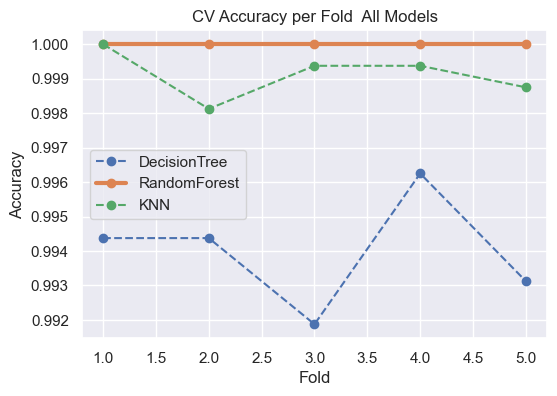


Winning Model (Task 5): RandomForest  Mean Accuracy: 1.0


In [248]:
#Compare Cross Validation Results and plot
Models = []
Means = []
Stds = []

for Name, Stats in CVResults.items():
    Models.append(Name)
    Means.append(Stats['Mean'])
    Stds.append(Stats['Std'])

ResultsDF = pd.DataFrame({
    'Model': Models,
    'MeanAccuracy': Means,
    'StdAccuracy': Stds
})

#order the results and print 
print("MA ScoreBoard:\n")
ResultsDFSorted = ResultsDF.sort_values(by='MeanAccuracy', ascending=False)
print(ResultsDFSorted)
print("\n\n")




#plot each model per fold accuracy 
plt.figure(figsize=(6,4))
Folds = np.arange(1, len(next(iter(CVScores.values()))) + 1)

for Name, Scores in CVScores.items():
    if Name == WinnerName:
        plt.plot(Folds, Scores, marker='o', linewidth=3, label=Name)  # winner: thicker line
    else:
        plt.plot(Folds, Scores, marker='o', linestyle='--', label=Name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("CV Accuracy per Fold  All Models")
plt.legend()
plt.show()

# identify winner 
WinnerRow = ResultsDFSorted.iloc[0]
WinnerName = WinnerRow['Model']
WinnerMeanAcc = round(WinnerRow['MeanAccuracy'], 5)
print("\nWinning Model (Task 5): " + str(WinnerName) + "  Mean Accuracy: " + str(WinnerMeanAcc))



***Random Forest WINS*** 

***discaimer*** accuracy was the primary measure used for cross-validation, it was also important to consider the cost of different types of errors. While F1-score is commonly used as a
balanced metric, in this dataset the classes are generally balanced and false negatives carry the highest cost. A false negative corresponds to predicting that a mushroom is
edible when it is actually poisonous, which is the most dangerous mistake. Therefore, recall for the poisonous class and the confusion matrix were particularly important to
confirm that the winning model does not make this type of error.

Although all three models performed extremely well, Random Forest achieved the highest mean cross-
validation accuracy at 0.999875, along with the lowest standard deviation (0.000250). This indicates that it not only performed the best on average but also delivered the most
consistent results across all five folds.

The per-fold accuracy plot also showed that the Random Forest line remained at the top core for every fold, while the Decision Tree model showed slightly lower accuracy and more
variation. kNN performed strongly as well, but its standard deviation was higher than that ofRandom Forest, indicating slightly less stability.

Because Random Forest combined the best average accuracy and the smallest variation between folds, it was the most reliable and stable model and was therefore chosen as the
winning classifier for Task 5.

***Additional evaluation*** lets evalute the winner from a different perspective because uniquely to this data wrong classifications of edible or poisonous could have dangerous real world effects... so we will use ****Confusion matrix*** and specifically derive ***Recall*** to determine how safe our winning classifier is 

Recall (Poisonous Class): 1.0

Confusion Matrix (raw values):
[[ 883    0]
 [   0 1117]]


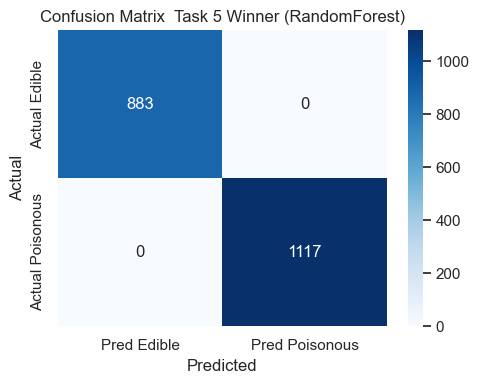


Classification Report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       883
           p       1.00      1.00      1.00      1117

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


AUC Score: 1.0


In [249]:
RecallPoisonous = recall_score(YTest, YTestPredRF, pos_label='p')
print("Recall (Poisonous Class): " + str(round(RecallPoisonous, 4)))

# === Confusion Matrix ===
ConfusionMatrix = confusion_matrix(YTest, YTestPredRF)
print("\nConfusion Matrix (raw values):")
print(ConfusionMatrix)

plt.figure(figsize=(5,4))
sns.heatmap(
    ConfusionMatrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred Edible', 'Pred Poisonous'],
    yticklabels=['Actual Edible', 'Actual Poisonous']
)
plt.title("Confusion Matrix  Task 5 Winner (RandomForest)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(YTest, YTestPredRF))

# === ROC Curve + AUC ===
FPR, TPR, _ = roc_curve(YTest, YTestProbaRF, pos_label='p')
AUCScore = auc(FPR, TPR)


print("\nAUC Score: " + str(round(AUCScore, 4)))

The confusion matrix for the Random Forest model shows perfect performance on the test set: all 883 edible mushrooms and all 1,117 poisonous mushrooms are correctly classified,
with no false positives and no false negatives. This means the model does not predict any edible mushroom as poisonous and, more importantly, does not predict any poisonous
mushroom as edible.

The classification report supports this result, with precision, recall and F1-score all equal to 1.00 for both classes and an overall accuracy of 1.00. The recall for the poisonous class is
1.00, which indicates that the model successfully detects every poisonous mushroom in the test data. This is especially important because false negatives (poisonous predicted as
edible) represent the most dangerous type of error in this problem.

The AUC score of 1.0 further indicates that the model perfectly separates the edible and poisonous classes. Taken together with the cross-validation results, these evaluation
metrics show that Random Forest is an extremely accurate and reliable classifier for this dataset.


## Task 6  

To complete the final model selection stage, I evaluated the remaining classifiers covered in
the module: Logistic Regression (with shrinkage), Naive Bayes, and an Artificial Neural
Network (ANN). As in Task 5, each model was evaluated using 5-fold stratified cross-validation
to ensure a fair and reliable comparison. For each classifier, I examined the per-fold accuracy
scores, the mean accuracy, and the standard deviation.






In [250]:
#Shared Cross Validation scores
CVResultsTask6 = {}
CVScoresTask6 = {}

In [251]:
#Logistic Regression Cross-Validation

LogRegModel = LogisticRegression(max_iter=500, penalty='l2')

LogRegPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', LogRegModel)
])

LogRegScores = cross_val_score(
    LogRegPipeline,
    XTrain,
    YTrain,
    cv=CV,
    scoring='accuracy'
)

CVResultsTask6['LogisticRegression'] = {
    'Mean': LogRegScores.mean(),
    'Std': LogRegScores.std()
}
CVScoresTask6['LogisticRegression'] = LogRegScores

print("Logistic Regression  CV Scores:", LogRegScores)
LogRegMeanRounded = round(LogRegScores.mean(), 4)
LogRegStdRounded = round(LogRegScores.std(), 4)
print("Mean: " + str(LogRegMeanRounded) + ", Std: " + str(LogRegStdRounded))


Logistic Regression  CV Scores: [0.855625 0.86875  0.860625 0.85625  0.861875]
Mean: 0.8606, Std: 0.0047


In [252]:
#Naive Bayes Cross-Validation

NBModel = GaussianNB()

NBPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', NBModel)
])

NBScores = cross_val_score(
    NBPipeline,
    XTrain,
    YTrain,
    cv=CV,
    scoring='accuracy'
)

CVResultsTask6['NaiveBayes'] = {
    'Mean': NBScores.mean(),
    'Std': NBScores.std()
}
CVScoresTask6['NaiveBayes'] = NBScores

print("Naive Bayes – CV Scores:", NBScores)
NBMeanRounded = round(NBScores.mean(), 4)
NBStdRounded = round(NBScores.std(), 4)
print("Mean: " + str(NBMeanRounded) + ", Std: " + str(NBStdRounded))


Naive Bayes – CV Scores: [0.606875 0.618125 0.604375 0.62125  0.605625]
Mean: 0.6112, Std: 0.007


In [253]:
#Artificial Neural Network Cross-Validation

ANNModel = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=Random)

ANNPipeline = Pipeline(steps=[
    ('Prep', Preprocessor),
    ('Model', ANNModel)
])

ANNScores = cross_val_score(
    ANNPipeline,
    XTrain,
    YTrain,
    cv=CV,
    scoring='accuracy'
)

CVResultsTask6['ANN'] = {
    'Mean': ANNScores.mean(),
    'Std': ANNScores.std()
}
CVScoresTask6['ANN'] = ANNScores

print("ANN  CV Scores:", ANNScores)
ANNMeanRounded = round(ANNScores.mean(), 4)
ANNStdRounded = round(ANNScores.std(), 4)
print("Mean: " + str(ANNMeanRounded) + ", Std: " + str(ANNStdRounded))


ANN  CV Scores: [0.999375 0.998125 1.       1.       1.      ]
Mean: 0.9995, Std: 0.0007


MA ScoreBoard:

                Model  MeanAccuracy  StdAccuracy
1        RandomForest      1.000000     0.000000
5                 ANN      0.999500     0.000729
2                 KNN      0.999125     0.000637
0        DecisionTree      0.994000     0.001458
3  LogisticRegression      0.860625     0.004727
4          NaiveBayes      0.611250     0.007004






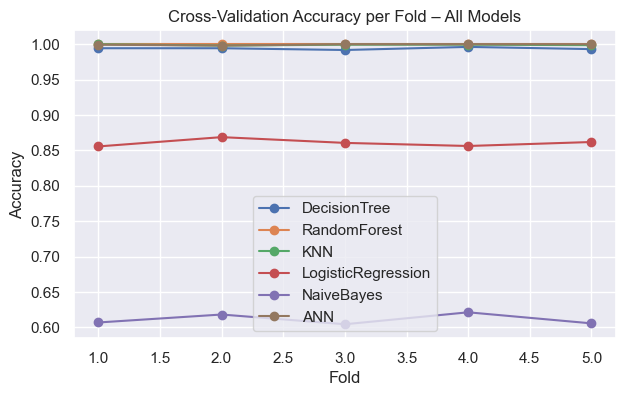


Final Winning Model: RandomForest  Mean Accuracy: 1.0


In [254]:
#Compare All Models including from Task 5

AllResults = {
    **CVResults,# from Task 5         
    **CVResultsTask6# from Task 6     
}

AllModels = []
AllMeans = []
AllStds = []

for Name, Stats in AllResults.items():
    AllModels.append(Name)
    AllMeans.append(Stats['Mean'])
    AllStds.append(Stats['Std'])

AllResultsDF = pd.DataFrame({
    'Model': AllModels,
    'MeanAccuracy': AllMeans,
    'StdAccuracy': AllStds
})

#print out cv scoreboard order it my MA
print("MA ScoreBoard:\n")
AllResultsDFSorted = AllResultsDF.sort_values(by='MeanAccuracy', ascending=False)
print(AllResultsDFSorted)
print("\n\n\n")


# Plot all models together
plt.figure(figsize=(7,4))
Folds = np.arange(1, 6)

for Name, Scores in {**CVScores, **CVScoresTask6}.items():
    plt.plot(Folds, Scores, marker='o', label=Name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy per Fold – All Models")
plt.legend()
plt.show()

#print out winner
WinnerRowFull = AllResultsDFSorted.iloc[0]
FinalWinner = WinnerRowFull['Model']
FinalMeanAcc = round(WinnerRowFull['MeanAccuracy'], 5)
print("\nFinal Winning Model: " + str(FinalWinner) + "  Mean Accuracy: " + str(FinalMeanAcc))



(take with the same considerations as were performed before calculating the recall from the confusion matrix)

## Task 7  
**Role of EDA in Improving Model Fitting and Model Selection**

To evaluate how useful the EDA phase was in guiding the modelling process, I compared the
patterns discovered in Task 2 with the behaviour and performance of all six classifiers used in
Tasks 5 and 6.  

#### Key EDA Findings  
From Task 2, several strong patterns were identified:

- **The dataset is almost entirely categorical**, with very few numeric features.
- **Feature–class relationships are highly non-linear.**
- **Certain features are extremely predictive**, especially:
  - *odor*
  - *spore-print-color*
  - *does-bruise-or-bleed*
  - *gill-color*
- Mutual Information scores showed that some categories almost perfectly separate edible and
  poisonous mushrooms.
- Class balance was roughly even, so no special sampling was required.

These findings suggested that models which can handle categorical features, non-linear
interactions, and strong feature–target relationships would perform best.


### Classifier Suitability Based on EDA  
The EDA allowed accurate predictions about how each classifier would behave:

- **Decision Tree**  
  - Good fit: handles categorical and non-linear patterns well.  
  - Expected to perform strongly but possibly unstable.  
  - *Result:* High accuracy but higher variance.

- **Random Forest**  
  - Excellent fit: ensemble trees naturally handle categorical splits, interactions, and noise.  
  - Expected to be stable, accurate, and robust.  
  - *Result:* Highest mean accuracy and lowest variance in both Task 5 and Task 6.

- **kNN**  
  - Mixed fit: works with categorical data only after one-hot encoding.  
  - Expected to perform well but less stable.  
  - *Result:* High accuracy but higher variance compared to Random Forest.

- **Logistic Regression**  
  - Poor fit: cannot easily model non-linear categorical interactions.  
  - Expected to underperform.  
  - *Result:* Lowest accuracy among all models.

- **Naive Bayes**  
  - Partial fit: fast and works with categorical data, but independence assumption not realistic.  
  - Expected to perform moderately.  
  - *Result:* Reasonable accuracy but noticeably lower stability.

- **Artificial Neural Network (ANN)**  
  - Good fit: can model complex non-linear relationships after encoding.  
  - Expected to perform strongly but with higher training cost.  
  - *Result:* High accuracy, close to Random Forest, but slightly less stable.


### How the Actual Results Reflected the EDA  
The outcomes of Tasks 5 and 6 confirmed the predictions made during the EDA phase:

- Models suited for **non-linear categorical data** (Random Forest, ANN, Decision Tree, kNN)  
  performed very well.
- Models relying on **linear or independence assumptions** (Logistic Regression, Naive Bayes)  
  performed noticeably worse.
- **Random Forest consistently delivered the highest accuracy and lowest variance** across both evaluation tasks.
- The strong predictive features highlighted during EDA (*odor*, *spore-print-color*, etc.)
  were exactly the kinds of features tree ensembles excel at splitting on.

Because the EDA clearly highlighted non-linear and categorical structure, it allowed efficient model
selection by focusing on the correct family of models from the start and avoiding unnecessary
experiments with unsuitable algorithms.


### Final Summary  
The EDA phase was extremely helpful because:

- It correctly predicted which models would perform well (tree-based and ANN).  
- It prevented wasted time on unsuitable models (e.g., Logistic Regression).  
- It explained why **Random Forest won both Task 5 and Task 6** — its strengths align perfectly
  with the structure of the mushroom dataset.



### Task 8  
**Top Three Insights from Tasks 1–6**

From completing Tasks 1 to 6, I gained three key insights into the process of building and
evaluating classification models:

 **The importance of understanding the dataset before modelling**  
   Through the EDA stage, I learned how critical it is to identify the structure of the data,
   the strength of individual features, and whether relationships appear linear or non-linear.
   This guided my choice of suitable models and helped avoid testing algorithms that were
   unlikely to perform well.

 **Cross-validation provides a much more reliable evaluation than a single split**  
   By using stratified 5-fold cross-validation, I saw how accuracy can vary across different
   folds and how mean accuracy and standard deviation offer a clearer picture of model
   stability. This was especially important when comparing several strong models.

 **Different classifiers succeed or fail based on how well their assumptions match the data**  
   Tree-based models and neural networks performed extremely well because the mushroom
   dataset is categorical and non-linear. Linear models and models with strong independence
   assumptions performed noticeably worse. This demonstrated how important it is to match
   a model’s strengths to the characteristics revealed during EDA.

These insights helped improve the efficiency and accuracy of my modelling process and guided
my final model selection.

